## **Advances in Data Mining**

Stephan van der Putten | (s1528459) | stvdputtenjur@gmail.com  
Theo Baart | s2370328 | s2370328@student.leidenuniv.nl

### **Assignment 3**
This assignment is concerned with performing an analysis of and execute PageRank on the wikipedia links given in the `wikilink_graph.2004-03-01.csv` file. In order to do this the assignment is split up into four subtasks with each subtask receiving its dedicated `.ipynb` file. See each specific file for details on what this notebook accomplishes.

Note all implementations are based on the assignment guidelines and helper files given as well as the documentation of the used functions. Additionally, the following sources are referenced:
  1. Mining of Masive Datasets by Jure Leskovec, Anand Rajaraman and Jeff ullman

#### **PageRank Algorithm (Improved)**
This notebook executes the PageRank algorithm using the improved storage method and algorithm as presented in the lecture (see also slide 18 of the instructional slideset). Additionally, some basic analaysis is performed and the results are compared to the "Sparse" implementation of PageRank.
___

### **Helper Functions**
This section contains functions which aid and simplify the code.
___
The following snippet handles all imports.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.sparse
from scipy.sparse import csr_matrix
from collections import defaultdict
from sklearn.preprocessing import normalize
import time

The class `PageRank` is our implementation for the Pagerank Algorithm

### **PageRankSparse Class**

This section contains the class and functions responsible for the sparse matrix implementation of the PageRank algorithm. Due to the limitations of `.ipynb` files the various functions will be described first and then the implementation will be shown.

___
The `__init__` function initializes the class.

In order to do this the function uses the following (optional) parameters:
  * `prepped_dataset` - the prepared link data [default: None]
  * `normalized_dataset` - the normalized link data [default: None]
___
The `load_prepped_data` function is responsible for retrieving the data prepped by `prep.ipynb` and loading it for exploratory data analysis.

In order to do this the function uses the following parameter:
  * `filename` - the name of the file containing the prepped data [default: `prep_data.npz`]
___
The `initialize_pagerank` function initializes the vectors and variables needed for pagerank.

In order to do this the function uses the following parameter:
  * `beta` - the value to use for Beta [default: `0.8`]
___
The `pagerank_iteration` function is responsible for executing a single iteration of PageRank using the sparse matrix implementation. 
___
The `run_pagerank` function runs page rank until the maximum number of iterations has been reached.

In order to do this the function uses the following parameter:
  * `max_iterations` - the maximum number of iterations to execute [default: `25`]
___  
The `analyze_mse` function plots the mse of the various PageRank iterations. 
___
The `compute_maximal_graph` function estimtes the maximal number of nodes (i.e. sources & destinations) such that this PageRank implementation can run on a system with the specified settings. The RAM computation is based on the description given in Section 5.2.1 of [1].

In order to do this the function uses the following parameters:
  * `max_ram` - the maximum RAM available in the system (in MB) [default: `1000`]
  * `out_degree` - the average out-degree of the graph [default: `15`]
  * `bits` - how many bits are needed to store a value [default: `64`]

In [23]:
class PageRankSparse():
    def __init__(self,prepped_dataset=None,normalized_dataset=None):
        self.prepped_dataset = prepped_dataset
        self.normalized_dataset = normalized_dataset
    
    def load_prepped_data(self,filename = 'prep_data.npz'):
        self.prepped_dataset = scipy.sparse.load_npz(filename) 
        
    def initialize_pagerank(self,beta=0.8):
        self.beta = 0.8
        self.mse = []
        self.runtimes = []
        self.normalized_dataset = normalize(self.prepped_dataset, norm='l1', axis=0)
        N = self.prepped_dataset.shape[0]
        
        self.v_original = np.repeat(1.0 / N , N)
        self.v_new = np.repeat((1-self.beta) / N, N)
        self.v_old =  self.v_original.copy()

    def pagerank_iteration(self):
        self.v_new = (self.beta * self.normalized_dataset * self.v_old) + (1 - self.beta)*(self.v_original)
        self.mse.append(((self.v_new - self.normalized_dataset * self.v_new)**2).mean())
        self.v_old = self.v_new.copy()
        
    def run_pagerank(self,max_iterations=25):
        for i in range(max_iterations):
            start = time.time()
            self.pagerank_iteration()
            end = time.time()
            self.runtimes.append(np.round(end - start,4))
            
    def analyze_mse(self):
        x_axis = list(range(len(self.mse)))
        y_axis = self.mse
        plt.plot(x_axis, y_axis)
        plt.xlabel('Iterations')
        plt.ylabel('MSE')
        plt.title('MSE over iterations')
        plt.show()
        
    def analyze_runtimes(self):
        x_axis = list(range(len(self.runtimes)))
        y_axis = self.runtimes
        plt.plot(x_axis, y_axis)
        plt.xlabel('Iterations')
        plt.ylabel('Runtime')
        plt.title('Runtime over iterations')
        plt.show()
        average = np.mean(self.runtimes)
        print(f'The average runtime is {average} seconds.')
        
    def compute_maximal_graph(self,max_ram=1000,out_degree=15,bits=64):
        max_bytes = max_ram * 1e6 # convert MB to bytes
        max_bits = max_bytes * 8 # bytes -> bits
        
        # nodes -> RAM requirements [taken from `eda.ipynb`]...
        # max_bits = (num_nodes * bits) + (num_nodes * out_degree * bits) + (num_nodes * out_degree * 64) [assuming 32 bit coordinates]
        # thus RAM -> nodes is...
        # num_nodes = max_bits / (bits + (out_degree * bits) + (out_degree * 64))
        num_nodes = max_bits / (bits + (out_degree * bits) + (out_degree * 64))
        num_nodes = np.floor(num_nodes)
        
        print(f'The maximum number of nodes is {num_nodes}.')        

### **Program Execution**
This section is concerned with parsing the input arguments and determining the execution flow of the program.
___
The `main` function handles the command line arguments and is responsible for the main flow of the program.

In order to do this the function uses the following parameters:
  * `path` - the location for the link data file [default: `prep_data.npz`]
  * `beta` - the Beta value to use [default: `0.8`]
  * `max_iter` - the maximum number of iterations to execute [default: `25`]

In [10]:
def main(path = 'prep_data.npz', beta=0.8,max_iter=25):
    sparse = PageRankSparse()
    sparse.load_prepped_data(path)
    
    sparse.initialize_pagerank(beta=beta)
    sparse.run_pagerank()
    
    sparse.analyze_mse()
    print('\n')
    sparse.analyze_runtimes()
    print('\n')    
    sparse.compute_maximal_graph()

The following snippet passes the start of the program and the command line arguments to the `main` function.

The following command line argument is expected:
  * `path` - the location of the `prep_data.npz` file
  * `beta` - the beta value to use
  * `max_iter` - the maximal number of Pagerank iterations

In [ ]:
if __name__ == "__main__":
    filepath = sys.argv[1]
    beta = sys.argv[2]
    max_iter = sys.argv[3]
    main(path=filepath,beta=beta,max_iter=max_iter)

The following snippet triggers the manual execuation of the program

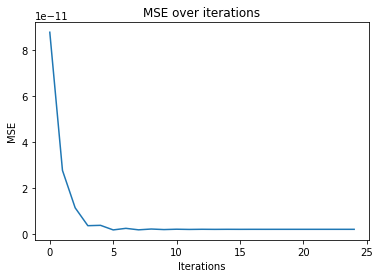

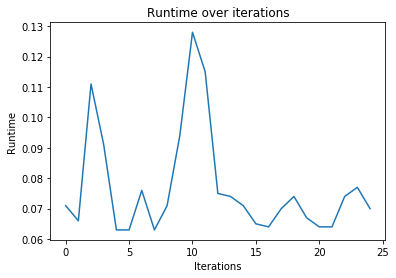

The average runtime is 0.07684 seconds.


The maximum number of nodes is 4032258.0.


In [24]:
main()